<a href="https://colab.research.google.com/github/mudita11/Covid-visual/blob/main/CWT_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
import nltk
import string
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, pairwise_distances, roc_auc_score, precision_score, recall_score, precision_recall_curve, mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

In [2]:
def count_unique(col, txt, sort_index):
    unique_restaurant = np.unique(col, return_counts = True)
    a = unique_restaurant[0]
    b = unique_restaurant[1]
    unique_restaurant_all = list(zip(a, b))
    print('Number of unique {} {}'.format(txt, len(unique_restaurant_all)))
    sorted_unique_restaurant_all = sorted(unique_restaurant_all, key=lambda t: t[sort_index], reverse=True)
    return a, b, sorted_unique_restaurant_all

In [3]:
df = pd.read_csv('London_reviews.csv', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
1,0.0,1,Cocotte_Notting_Hill,5.0,Positive,review_771556136,JUST PERFECT,I was away for couple of months and I am so h...,I was away for couple of months and I am so ha...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
2,1.0,2,Cocotte_Notting_Hill,5.0,Positive,review_771555883,"Quality food, Food travels well, Excellent cus...",I recently ordered over the phone from Cocotte...,I recently ordered over the phone from Cocotte...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
3,2.0,3,Cocotte_Notting_Hill,5.0,Positive,review_770716943,Came here because we missed,Came here because we missed our table at Farma...,Came here because we missed our table at Farma...,"September 17, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
4,3.0,4,Cocotte_Notting_Hill,5.0,Positive,review_770027676,Great service,My first time in cocotte and was amazed by how...,My first time in cocotte and was amazed by how...,"September 12, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_3


In [5]:
arr = df.to_numpy()

Shape and columns

In [6]:
print('(Number of rows, number of columns) - {}'.format(np.shape(arr)))
arr[0][0]='Index'
all_columns = {item:idx for idx, item in enumerate(arr[0])}
all_columns
arr = arr[1:]

(Number of rows, number of columns) - (8066, 13)


{'Index': 0,
 'parse_count': 1,
 'restaurant_name': 2,
 'rating_review': 3,
 'sample': 4,
 'review_id': 5,
 'title_review': 6,
 'review_preview': 7,
 'review_full': 8,
 'date': 9,
 'city': 10,
 'url_restaurant': 11,
 'author_id': 12}

Convert column type
restaurant_name: str
title_review: str
review_full: str
city: str

In [7]:
arr[:, all_columns['restaurant_name']] = arr[:, all_columns['restaurant_name']].astype('str')
arr[:, all_columns['title_review']] = arr[:, all_columns['title_review']].astype('str')
arr[:, all_columns['city']] = arr[:, all_columns['city']].astype('str')

Count unique restaurants

In [8]:
sorted_unique, a, b = count_unique(arr[:, all_columns['restaurant_name']], 'restaurant', 1)
sorted_unique[-5:]

Number of unique restaurant 23


array(['The_Gojk', 'The_Monsoon',
       'The_Vincent_Room_Brasserie_Bar_Escoffier_Room',
       'Trattoria_Raffaele', 'Wild_Thyme'], dtype=object)

Review 'rating_review' column and remove rows with incorrect values

In [9]:
#rating_review column
arr[:, all_columns['rating_review']]

array(['5.0', '5.0', '5.0', ..., '5.0', '5.0', nan], dtype=object)

In [10]:
strings = ['', ' ', 'London_England']
rows_to_delete = [i for i, item in enumerate(arr[:, all_columns['rating_review']]) if item in strings]
print('Ratings as string {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings as string []


Change type, rating_review: int

In [11]:
arr[:, all_columns['rating_review']] = arr[:, all_columns['rating_review']].astype('float').astype('int')

Remove rows based rating_review incorrect values

In [12]:
rows_to_delete = [(np.where(arr[:, all_columns['rating_review']]<0) or (arr[:, all_columns['rating_review']]>5))]
print('Ratings with incorrect score {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings with incorrect score [(array([8064]),)]


Counts of unique rating_review

Number of unique ratings 5


[(5, 6622), (4, 936), (3, 296), (1, 107), (2, 103)]

<BarContainer object of 5 artists>

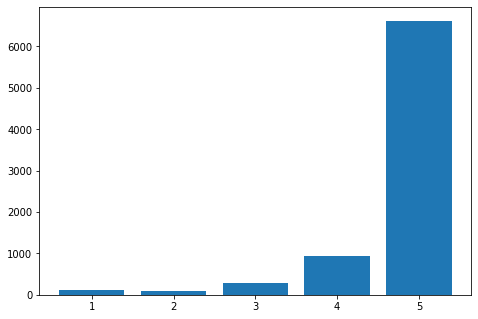

In [13]:
#1-3: Negative, 4-5: Positive
a, b, sorted_unique = count_unique(arr[:, all_columns['rating_review']], 'ratings', 1)
sorted_unique[-10:]
### Bar plot for rating_review count
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(a, b)
plt.show()

Number of positive vs negative reviews

Number of unique sentiment 2


[('Positive', 7558), ('Negative', 506)]

<BarContainer object of 2 artists>

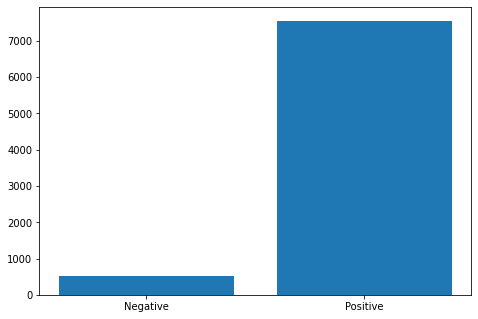

In [14]:
a, b, sorted_unique = count_unique(arr[:, all_columns['sample']], 'sentiment', 1)
sorted_unique
### Bar plot for sample count
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(a, b)
plt.show()

Remove nan reviews

In [16]:
nan_review = [idx for idx, item in enumerate(arr[:, all_columns['review_full']]) if isinstance(item, float)]
print('Row index with nan reviews {}'.format(nan_review))
arr = np.delete(arr, rows_to_delete, 0)

Row index with nan reviews []


IndexError: ignored

In [17]:
arr[:, all_columns['review_full']] = arr[:, all_columns['review_full']].astype('str')
arr[:, all_columns['review_full']][:3]

array(['I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at home again thanks to COCOTTE.',
       "I recently ordered over the phone from Cocotte to collect for a gathering at home. On calling the restaurant for the delivery, the service was polite, well communicated and friendly. The person on the phone had a great knowledge of the menu and gave helpful suggestions for customer favourites. The food was ready to collect swiftly at the time we requested and was well packaged for the journey home. The food itself traveled well which is fantastic, the food remained warm and as tasty as when we've eaten on site. All in all what a fabulous night made perfect by Cocottes tasty food and efficient service.",
       'Came here because we missed our table at Farmacy across the road. The waitress accom

Change type, date: str and datetime format

In [18]:
arr[:, all_columns['date']] = arr[:, all_columns['date']].astype('str')
arr[:, all_columns['date']][:10]
wo_nan_date = [item for item in arr[:, all_columns['date']] if item != 'nan']
min(wo_nan_date)
max(wo_nan_date)

array(['September 23, 2020', 'September 23, 2020', 'September 17, 2020',
       'September 12, 2020', 'August 22, 2020', 'August 21, 2020',
       'August 10, 2020', 'August 8, 2020', 'August 7, 2020',
       'July 14, 2020'], dtype=object)

'April 1, 2011'

'September 9, 2020'

Count unique cities

In [19]:
unique_city = np.unique(arr[:, all_columns['city']], return_counts = True)
unique_city_all = list(zip(unique_city[0],unique_city[1]))
print('Number of unique cities {}'.format(len(unique_city_all)))
sorted_unique_city_all = sorted(unique_city_all, key=lambda t: t[1], reverse=True)
sorted_unique_city_all

Number of unique cities 1


[('London_England', 8064)]

Drop unnecessary columns

In [20]:
drop_col = ['Index', 'parse_count', 'restaurant_name', 'sample', 'review_id', 'review_preview', 'date', 'city',  'url_restaurant','author_id'] 
col_to_delete = [all_columns[item] for item in drop_col]
arr = np.delete(arr, col_to_delete, 1)

In [73]:
merge_txt = arr[:,1]+' '+arr[:,2]
merge_txt[0]

'JUST PERFECT I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at home again thanks to COCOTTE.'

Pre-process text

In [75]:
def process(sentence):
    # Remove special charaters
    output = re.findall('[\w]+', sentence.lower())
    # Remove digits
    output = [re.sub(r'\d+', '', item) for item in output]
    # Remove urls
    output = [re.sub(r'http\S+', '', item) for item in output]
    #work level tokenise
    #word_list = nltk.word_tokenize(output)
    # lemmatize
    tokens = [lemmatizer.lemmatize(word=item) for item in output if item not in stop]
    # if using TfidfVectorizer or CountVectorizer, as they expect sentence and not tokens. They tokenise themselves.
    tokens = (' ').join(tokens)
    return tokens

In [76]:
#Initialise lemmatizer
lemmatizer = WordNetLemmatizer()
# stop words
stop = set(stopwords.words('english') + list(string.punctuation))
stop.add('')
processed_reviews = [process(sent) for sent in data[:,1]]
processed_reviews[0]

Vector representation

In [86]:
vectorizer = TfidfVectorizer()#CountVectorizer()
X = vectorizer.fit_transform(processed_reviews)
Y = arr[:,0]
print(np.shape(X))
print(np.shape(Y))

(8064, 14171)
(8064,)


Train-Test split

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
Y_train=Y_train.astype('int')
Y_test=Y_test.astype('int')
print(np.shape(X_train), np.shape(X_test), np.shape(Y_train), np.shape(Y_test))

(6048, 14171) (2016, 14171) (6048,) (2016,)


Random Forest Classifier

In [98]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, Y_train)
Y_predict_train = rfc.predict(X_train)
Y_predict_test = rfc.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

RandomForestClassifier(max_depth=2, random_state=0)

Accuracy Score (Train set): 0.8202711640211641
Accuracy Score (Test set): 0.8239087301587301


In [102]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

LogisticRegression()

Accuracy Score (Train set): 0.8697089947089947
Accuracy Score (Test set): 0.8308531746031746


In [105]:
lin = LogisticRegression()
lin.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'MSE (Train set): {mean_squared_error(Y_train, Y_predict_train)}')
print(f'MSE (Test set): {mean_squared_error(Y_test, Y_predict_test)}')

LogisticRegression()

MSE (Train set): 0.41418650793650796
MSE (Test set): 0.48313492063492064


In [83]:
#data = np.transpose(np.vstack((arr[:,0], processed_reviews)))
#np.shape(data)
#data[0]

(8065,)

5

In [57]:
#nltk.download('punkt')
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True